### Customer retention Analytics

##### Business Problem:
An International bank collected a sample data of 10,000 customers. They observed that some of their custimers are leaving or churning in an unusually high rate and they want to find understand and access why their customers keep leaving. They have hiered you as a data scientist to look into the data to give then some insight.

##### Data:
The data was collected within the last 5 months, the feautures include the customer's name, creditscore, geography, gendey,age,tenure,balnce, number of products(accounts),credit card status(whether they have one or not), estimated salary, activity status(active member or not) and if the customer remained with them.

#### Goal:
Your goal is to create a geodemographic segmentation  to identify which of the customers have the highest risk of leaving.

### installing necessary packages

In [1]:
!python -m pip install --user --upgrade pip

!pip3 install pandas==0.23.4 matplotlib==3.0.3 seaborn==0.9.0 torch==1.7.1 scikit-learn==0.22

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

### Working on a banking dataset to detect churn activities

In [3]:
#importing the data
data = pd.read_csv("https://raw.githubusercontent.com/MavenCode/KubeflowTraining/master/Data/Churn_Modelling.csv")

In [4]:
#viewing the data
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


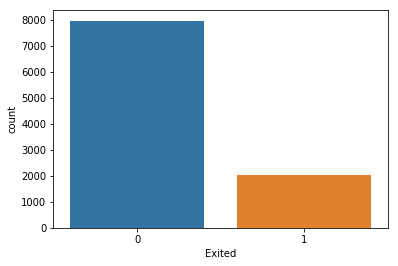

In [5]:
#frequency of the target classes
sns.countplot(x='Exited', data=data)

From the data we have more information on the customers that stayed at the bank

In [6]:
#checking for datatype of each column
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [7]:
#checking for missing values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [8]:
#dropping some columns that are not needed
data = data.drop(columns=['RowNumber','CustomerId','Surname'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
#viewing the unique values in Geography column
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [10]:
#data features
X = data.iloc[:,:-1]
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [11]:
#target data
y = data.iloc[:,-1:]
y.head()

,Exited
0,1
1,0
2,1
3,0
4,0


In [12]:
#encoding the categorical columns
le = LabelEncoder()
ohe = OneHotEncoder()
X['Gender'] = le.fit_transform(X['Gender'])
geo_df = pd.DataFrame(ohe.fit_transform(X[['Geography']]).toarray())

#getting feature name after onehotencoding
geo_df.columns = ohe.get_feature_names(['Geography'])

#merging geo_df with the main data
X = X.join(geo_df)
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,France,0,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0
3,699,France,0,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0


In [13]:
#dropping the old columns after encoding
X.drop(columns=['Geography'], axis=1, inplace=True)
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0


### Split Data

In [14]:
X_train,X_test,y_train,y_test = train_test_split( X,y, test_size=0.2, random_state = 42)

In [15]:
data_dict = {"X_train":X_train, "X_test":X_test, "y_train":y_train, "y_test":y_test}
for i in data_dict:
    print("The shape of {} is {}".format(i,data_dict[i].shape))

The shape of X_train is (8000, 12)
The shape of X_test is (2000, 12)
The shape of y_train is (8000, 1)
The shape of y_test is (2000, 1)


### Feature scaling

In [16]:
sc =StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Deep learning model

In [27]:
#setting model hyper-parameters
EPOCHS = 25
BATCH_SIZE =10
LEARNING_RATE = 0.001

In [18]:
X_test.shape

(2000, 12)

#### Defining custom dataset

In [19]:
#train data
class trainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self,index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.X_data)

train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train.values))

In [20]:
#test data
class testData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self,index):
        return self.X_data[index]
    
    def __len__(self):
        return len(self.X_data)

test_data = testData(torch.FloatTensor(X_test))

### Defining dataloader to read dataset class in batches

In [21]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(dataset=test_data, batch_size=1)

### defining neural network architecture

In [22]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        #number of input features is 12
        self.layer_1 = nn.Linear(12, 16)
        self.layer_2 = nn.Linear(16, 8)
        self.layer_out = nn.Linear(8, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(8)
        
    #feed forward network
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [24]:
#initializing optimizer and loss
classifier = binaryClassification()
print(classifier)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr = LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=8, bias=True)
  (layer_out): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [25]:
#function to calculate accuracy
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    results_sum = (y_pred_tag == y_test).sum().float()
    acc = results_sum/y_test.shape[0]
    acc =torch.round(acc*100)
    return acc

In [28]:
#training the model
classifier.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        #setting gradient to 0 per mini-batch
        optimizer.zero_grad()
        y_pred = classifier(X_batch)
        loss =criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        print(f'Epoch {e+0:03}: | Loss:{epoch_loss/len(train_loader):.5f} | Acc:{epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss:0.00121 | Acc:0.075
Epoch 001: | Loss:0.00141 | Acc:0.200
Epoch 001: | Loss:0.00182 | Acc:0.312
Epoch 001: | Loss:0.00255 | Acc:0.412
Epoch 001: | Loss:0.00313 | Acc:0.487
Epoch 001: | Loss:0.00355 | Acc:0.588
Epoch 001: | Loss:0.00384 | Acc:0.713
Epoch 001: | Loss:0.00402 | Acc:0.838
Epoch 001: | Loss:0.00432 | Acc:0.950
Epoch 001: | Loss:0.00450 | Acc:1.075
Epoch 001: | Loss:0.00528 | Acc:1.175
Epoch 001: | Loss:0.00564 | Acc:1.288
Epoch 001: | Loss:0.00639 | Acc:1.387
Epoch 001: | Loss:0.00661 | Acc:1.500
Epoch 001: | Loss:0.00687 | Acc:1.625
Epoch 001: | Loss:0.00768 | Acc:1.700
Epoch 001: | Loss:0.00811 | Acc:1.800
Epoch 001: | Loss:0.00837 | Acc:1.913
Epoch 001: | Loss:0.00883 | Acc:2.013
Epoch 001: | Loss:0.00975 | Acc:2.087
Epoch 001: | Loss:0.00992 | Acc:2.212
Epoch 001: | Loss:0.01024 | Acc:2.312
Epoch 001: | Loss:0.01038 | Acc:2.438
Epoch 001: | Loss:0.01061 | Acc:2.562
Epoch 001: | Loss:0.01122 | Acc:2.663
Epoch 001: | Loss:0.01185 | Acc:2.775
Epoch 001: |

In [29]:
#test model
y_pred_list = []
classifier.eval()
#ensures no back propagation during testing and reduces memeory usage
with torch.no_grad():
    for X_batch in test_loader:
        y_test_pred = classifier(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        
        y_pred_list.append(y_pred_tag.cpu().numpy())
    y_pred_list = [i.squeeze().tolist() for i in y_pred_list] 
    #y_pred_list = [bool(i) for i in y_pred_list]

In [30]:
acc = binary_acc(torch.FloatTensor(y_pred_list), torch.FloatTensor(y_test.values))
accu = acc.item()
print("Accuracy is ",accu/len(y_test), "%")

Accuracy is  74.9175 %


In [31]:
#confusion matrix
cm = confusion_matrix(y_test,y_pred_list)
print(cm)

[[1576   31]
 [ 245  148]]


From our confusion matrix we conclude that:
1. **True positive:** 148(We predicted a positive result and it was positive)- the model rightly predicted the ones who left the bank 
2. **True negative:** 1576(We predicted a negative result and it was negative)-the model rightly predicted the ones who stayed at the bank 
3. **False positive:** 31(We predicted a positive result and it was negative)-the model predicted that these ones left when they actually stayed
4. **False negative:** 245(We predicted a negative result and it was positive)- the model predicted that these ones stayed when they actually left

In [32]:
#classification report
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1607
           1       0.83      0.38      0.52       393

    accuracy                           0.86      2000
   macro avg       0.85      0.68      0.72      2000
weighted avg       0.86      0.86      0.84      2000

